# Gaussian mixture model HMM on example session

In [3]:
""" 
IMPORTS
"""
import os
import sys
import autograd.numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

from itertools import count
from one.api import ONE

from functools import partial
from jax import vmaphttps://github.com/mattjj/pyslds
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM
from dynamax.hidden_markov_model import GaussianMixtureHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from functions import plot_transition_matrix, cross_validate_model

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


### Get design matrix

In [4]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/'
#data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'

os.chdir(data_path)

big_design_matrix = pickle.load(open("design_matrix_wheel_lick_pupil", "rb"))

Preprocess design matrix

In [5]:
big_design_matrix['Lick count'] = big_design_matrix['Lick count'].replace(np.NaN, 0)
design_matrix = big_design_matrix.groupby('Bin')['Lick count', 'avg_wheel_vel', 'wheel_subtracted', 'pupil_subtracted'].mean()
design_matrix = design_matrix.reset_index(level=[0])
design_matrix = design_matrix.dropna()

/tmp/ipykernel_8656/1465712216.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  design_matrix = big_design_matrix.groupby('Bin')['Lick count', 'avg_wheel_vel', 'wheel_subtracted', 'pupil_subtracted'].mean()


Get session data for corresponding session (only one available for now)

In [6]:
one = ONE()
example_session = 'cb2ad999-a6cb-42ff-bf71-1774c57e5308'

# Trials data
session_trials = one.load_object(example_session, obj='trials', namespace='ibl')
session_trials = session_trials.to_df()

Downloading: /home/ines/Downloads/ONE/alyx.internationalbrainlab.org/tmpm43nhn3c/cache.zip Bytes: 105983977


100%|██████████| 101.07419681549072/101.07419681549072 [00:16<00:00,  6.01it/s]


To transform Poisson data into a Gaussian (normal) distribution, you can use a square root transformation or the Anscombe transformation. These transformations are common methods used to approximate a normal distribution from Poisson data.
- Square Root Transformation: The square root transformation is a simple method to stabilize the variance of Poisson data and make it more approximately Gaussian. For each data point x, you take the square root of x:

- Anscombe Transformation: The Anscombe transformation is a more sophisticated transformation that stabilizes the variance and approximates the normal distribution for Poisson data. It is defined as:

In [16]:
# TODO: this should be moved to the design_matrix code?
# Transform licks
def anscombe_transform(x):
    return 2 * np.sqrt(x + 3/8)
#design_matrix['Gaussian_licks'] = anscombe_transform(design_matrix['Lick count'])
design_matrix['Gaussian_licks'] = np.sqrt(design_matrix['Lick count'])
#design_matrix['Gaussian_licks'] = np.log(design_matrix['Lick count']+0.1)

In [17]:
design_matrix['Gaussian_licks']

122      0.0
123      0.0
124      0.0
125      0.0
126      0.0
        ... 
44159    0.0
44160    0.0
44161    0.0
44162    0.0
44163    0.0
Name: Gaussian_licks, Length: 44042, dtype: float64

(array([4.3392e+04, 0.0000e+00, 0.0000e+00, 3.0000e+00, 1.1900e+02,
        3.6900e+02, 2.0000e+00, 4.3000e+01, 1.0600e+02, 8.0000e+00]),
 array([0.        , 0.17320508, 0.34641016, 0.51961524, 0.69282032,
        0.8660254 , 1.03923048, 1.21243557, 1.38564065, 1.55884573,
        1.73205081]),
 <BarContainer object of 10 artists>)

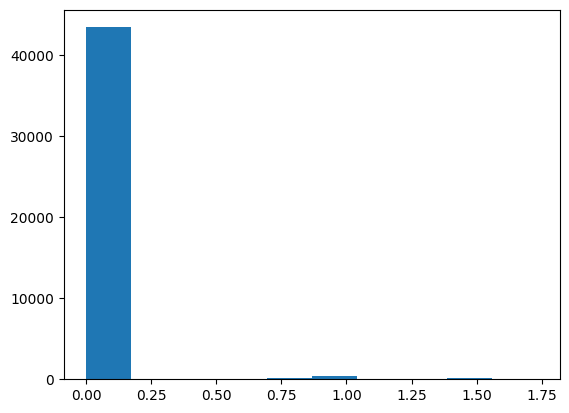

In [18]:
plt.hist(design_matrix['Gaussian_licks'])

In [ ]:
#inpt = np.array(design_matrix[['Lick count', 'avg_wheel_vel', 'wheel_subtracted', 'pupil_subtracted']])
#inpt = np.array(design_matrix[['avg_wheel_vel', 'wheel_subtracted', 'pupil_subtracted']]).copy()
inpt = np.array(design_matrix[['Gaussian_licks', 'avg_wheel_vel', 'wheel_subtracted', 'pupil_subtracted']]).copy()
#inpt = np.array(design_matrix[['avg_wheel_vel', 'wheel_subtracted']]).copy()

# Standardization using StandardScaler
scaler = StandardScaler()
standardized_matrix = scaler.fit_transform(inpt)
standardized_matrix = inpt


## Parameters

In [77]:
emission_dim = np.shape(inpt)[1]
num_timesteps = np.shape(inpt)[0]
num_iters = 100
num_train_batches = 5
last_state = 20  # Test up until last_state Ks
num_components = np.arange(2, emission_dim+1, 1)  # Test up until emission_dim, starting at 1 (number of clusters)

## Cross-validate and compare models with different K

In [78]:
def cross_validate_model(model, key, train_emissions, num_train_batches, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    init_params, props = model.initialize(key=key, method="kmeans", emissions=train_emissions)
    
    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack([
        jnp.concatenate([train_emissions[:i], train_emissions[i+1:]])
        for i in range(num_train_batches)])

    def _fit_fold_baseline(y_train, y_val):
        return model.marginal_log_prob(init_params, y_val)
    
    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(init_params, props, y_train, 
                              [:, 1]               num_iters=num_iters, verbose=False)
        return model.marginal_log_prob(fit_params, y_val), fit_params

    val_lls, fit_params = vmap(_fit_fold)(folds, train_emissions)
    
    baseline_val_lls = vmap(_fit_fold_baseline)(folds, train_emissions)
    
    return val_lls.mean(), val_lls, fit_params, init_params, baseline_val_lls


In [79]:
for c, component in enumerate(num_components):
    
    print('Fitting models with ' + str(component) + ' Gaussian components')
    # Shorten array so that equal division is possible
    shortened_array = standardized_matrix[:num_timesteps // num_train_batches * num_train_batches]
    # Split data into folds
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
    fold_len =  len(shortened_array)/num_train_batches

    # Make a range of Gaussian HMMs
    all_num_states = list(range(2, last_state))
    test_hmms = [GaussianMixtureHMM(num_states, component, emission_dim, transition_matrix_stickiness=10.) 
            for num_states in all_num_states]
    results = []
    for test_hmm in test_hmms:
        print(f"fitting model with {test_hmm.num_states} states")
        results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches))

    avg_val_lls, all_val_lls, fit_params, init_params, baseline_lls = tuple(zip(*results))
    
    if c == 0:
        component_lls = avg_val_lls
        component_baseline_lls = np.mean(baseline_lls, axis=1)
    else:
        component_lls = np.vstack((component_lls, avg_val_lls))
        component_baseline_lls = np.vstack((component_baseline_lls, np.mean(baseline_lls, axis=1)))

Fitting models with 2 Gaussian components
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 11 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 13 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 15 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 17 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 19 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting models with 3 Gaussian components
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 11 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 13 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 15 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 17 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 19 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Fitting models with 4 Gaussian components
fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 11 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 13 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 15 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 17 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 19 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [103]:
# Shorten array so that equal division is possible
shortened_array = standardized_matrix[:num_timesteps // num_train_batches * num_train_batches]
# Split data into folds
train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
fold_len =  len(shortened_array)/num_train_batches

# Make a range of Gaussian HMMs
all_num_states = list(range(2, last_state))
test_hmms = [GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.) 
          for num_states in all_num_states]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches))

avg_val_lls, all_val_lls, fit_params, init_params, baseline_lls = tuple(zip(*results))

fitting model with 2 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 10 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 11 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 12 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 13 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 14 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 15 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 16 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 17 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 18 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 19 states


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Calculate model assessment metrics

In [105]:
States = np.arange(2, last_state, 1)

Ks = np.array([(num_states + num_states*num_states + num_states*emission_dim*2) 
          for num_states in States])  # pi_init + transition_matrix + predictors_mean + predictors_var 

AIC = Ks * 2 - 2 * np.array(avg_val_lls)
BIC = Ks * np.log(fold_len) - 2 * np.array(avg_val_lls)

bits_LL = (np.array(avg_val_lls) - np.mean(baseline_lls, axis=1)) / fold_len * np.log(2)
delta_LL = np.array(avg_val_lls) - np.mean(baseline_lls, axis=1)

delta_AIC = AIC - Ks * 2 - 2 * np.mean(baseline_lls, axis=1)

delta_BIC = BIC - Ks * np.log(fold_len) - 2 * np.mean(baseline_lls, axis=1)

In [106]:
bits_LL_gau = bits_LL

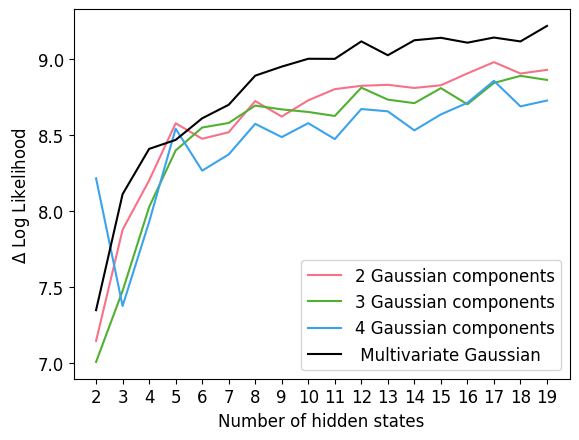

In [108]:
States = np.arange(2, last_state, 1)

def generate_colors(num_colors):
    # Use seaborn's color_palette to generate a list of colors
    return sns.color_palette('husl', n_colors=num_colors)

# Generate the list of colors
colors = generate_colors(len(num_components))
    
for c, component in enumerate(num_components):
    avg_val_lls = component_lls[c]
    baseline_lls = component_baseline_lls[c]
    
    bits_LL = (np.array(avg_val_lls) - np.array(baseline_lls)) / fold_len * np.log(2)
    plt.plot(all_num_states, bits_LL, color=colors[c], label=str(str(component)+' Gaussian components'))
    plt.legend()
    plt.xticks(States)
    plt.xlabel("Number of hidden states")
    plt.ylabel("$\Delta$ Log Likelihood ")
plt.plot(all_num_states, bits_LL_gau, color='black', label=' Multivariate Gaussian')
plt.legend()

In [71]:
str(str(component)+' Gaussian components')

'3 Gaussian components'

Text(0, 0.5, 'Delta AIC')

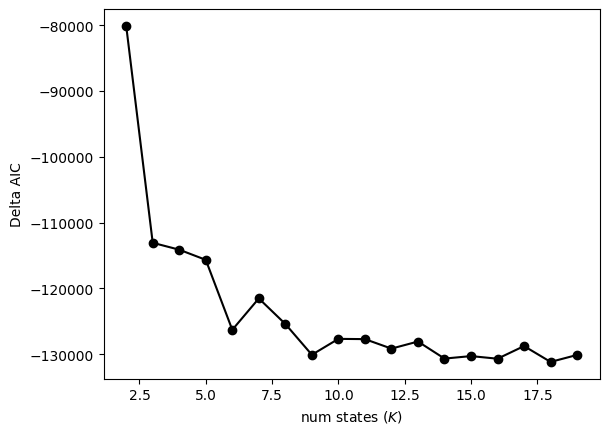

In [12]:
plt.plot(all_num_states, delta_AIC, '-ko')

plt.xlabel("num states ($K$)")
plt.ylabel("Delta AIC")

Text(0, 0.5, 'Delta BIC')

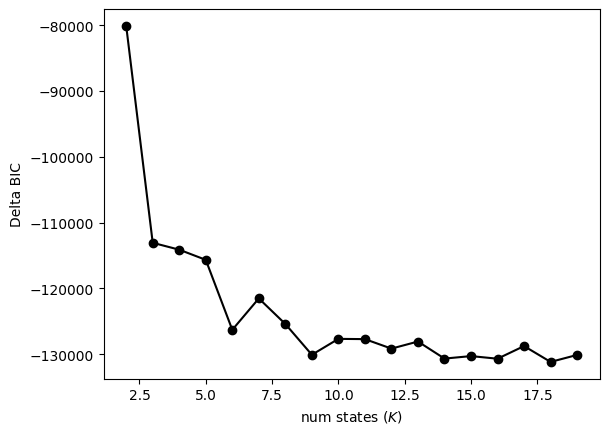

In [13]:
plt.plot(all_num_states, delta_BIC, '-ko')

plt.xlabel("num states ($K$)")
plt.ylabel("Delta BIC")

Text(0, 0.5, 'Akaike Information Criterion')

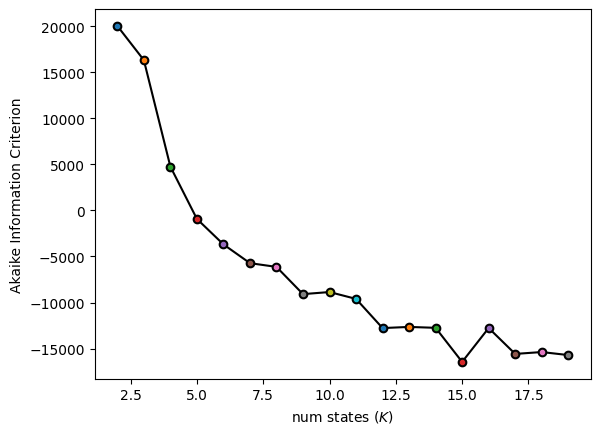

In [154]:
plt.plot(all_num_states, BIC, '-ko')
for k, per_fold_val_lls in zip(all_num_states, BIC):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("Akaike Information Criterion")

Text(0, 0.5, 'Akaike Information Criterion')

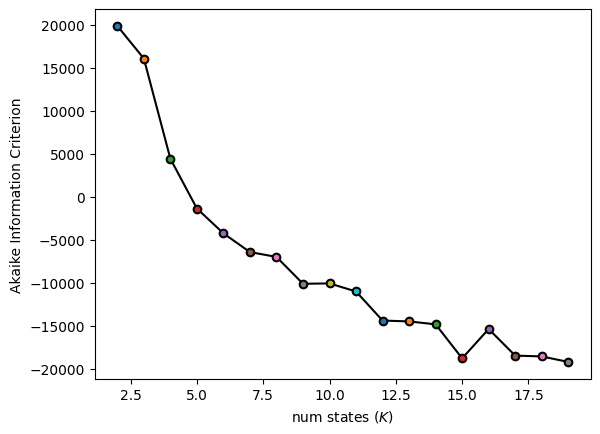

In [155]:
plt.plot(all_num_states, AIC, '-ko')
for k, per_fold_val_lls in zip(all_num_states, AIC):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("Akaike Information Criterion")

Text(0, 0.5, 'avg. validation log prob.')

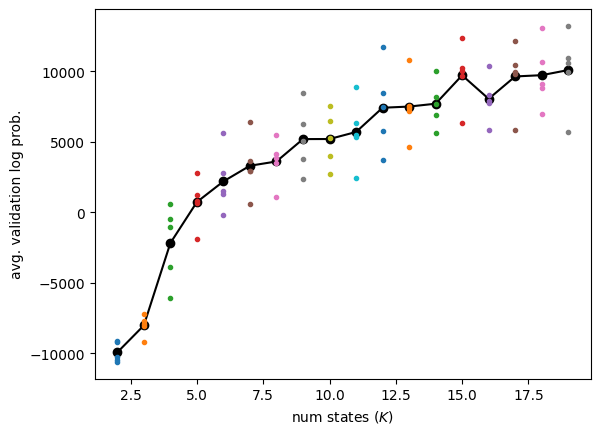

In [157]:
plt.plot(all_num_states, avg_val_lls, '-ko')
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, '.')
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")

## Fit optimal-state Gaussian HMM

In [83]:
num_states = 5  #This needs to be chosen manually!
component = 2

In [84]:
shortened_array = standardized_matrix[:num_timesteps // num_train_batches * num_train_batches]
train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
#test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
test_hmm = GaussianMixtureHMM(num_states, component, emission_dim, transition_matrix_stickiness=10.) 
mean_val_lls, val_lls, fit_params, init_params, baseline_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), train_emissions, num_train_batches)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Plot results

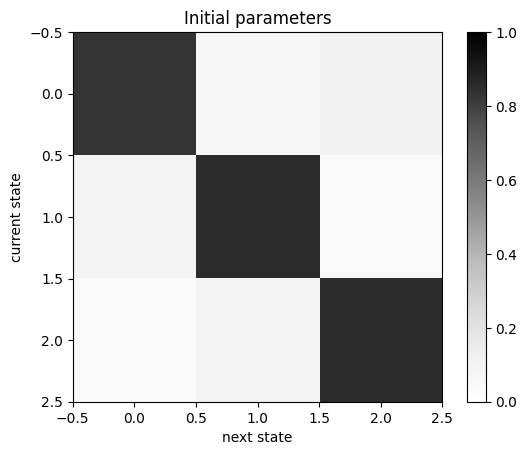

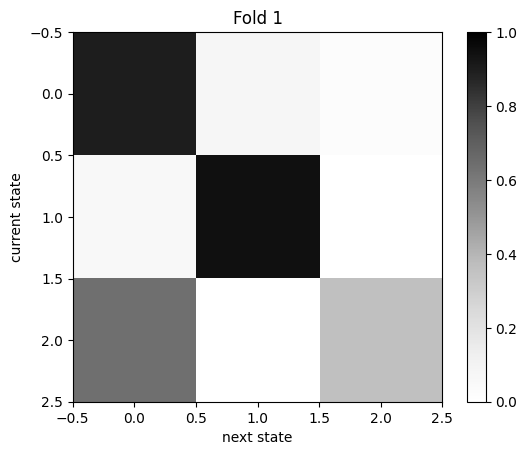

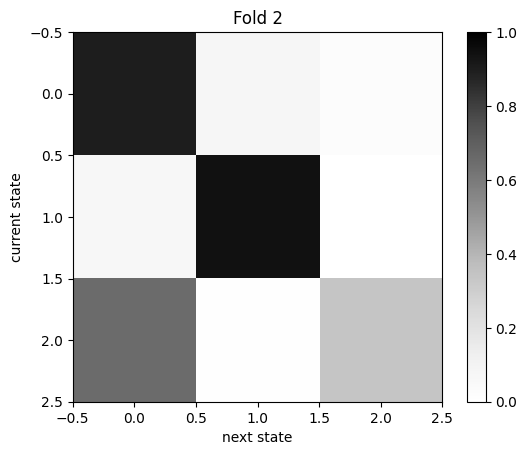

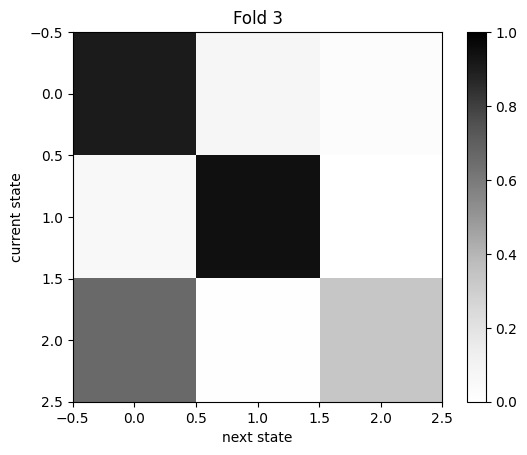

Array([[9.0302479e-01, 7.4513860e-02, 2.2461368e-02],
       [5.8130261e-02, 9.4175225e-01, 1.1744208e-04],
       [6.6042095e-01, 4.9570519e-03, 3.3462209e-01]], dtype=float32)

In [12]:
plt.title('Initial parameters')
plot_transition_matrix(init_params[1].transition_matrix)
init_params[1].transition_matrix

plt.title('Fold 1')
plot_transition_matrix(fit_params[1].transition_matrix[0])
fit_params[1].transition_matrix[0]
plt.title('Fold 2')
plot_transition_matrix(fit_params[1].transition_matrix[1])
fit_params[1].transition_matrix[1]
plt.title('Fold 3')
plot_transition_matrix(fit_params[1].transition_matrix[2])
fit_params[1].transition_matrix[2]


In [86]:
state_means

{'Licks': Array([[0.       , 0.       , 0.       , 0.       , 1.0420597],
        [0.       , 0.       , 0.       , 0.       , 1.0420597]],      dtype=float32),
 'Wheel velocity': Array([[ 1.4555797e-02,  1.3528564e-03,  1.2697054e-04, -4.2056191e-01,
          3.7985913e-02],
        [ 1.4555797e-02,  1.3528564e-03,  1.2697054e-04, -4.2056191e-01,
          3.7985913e-02]], dtype=float32),
 'Wheel displacement': Array([[-9.2619372e-04,  4.2152669e-02,  4.7697473e-04, -1.1195651e+00,
         -6.7085256e-03],
        [-9.2619372e-04,  4.2152669e-02,  4.7697473e-04, -1.1195651e+00,
         -6.7085256e-03]], dtype=float32),
 'Pupil size': Array([[ 1.0317593 ,  0.69891876, -1.1505191 ,  4.3674836 ,  1.202293  ],
        [ 1.0317593 ,  0.69891876, -1.1505191 ,  4.3674836 ,  1.202293  ]],      dtype=float32)}

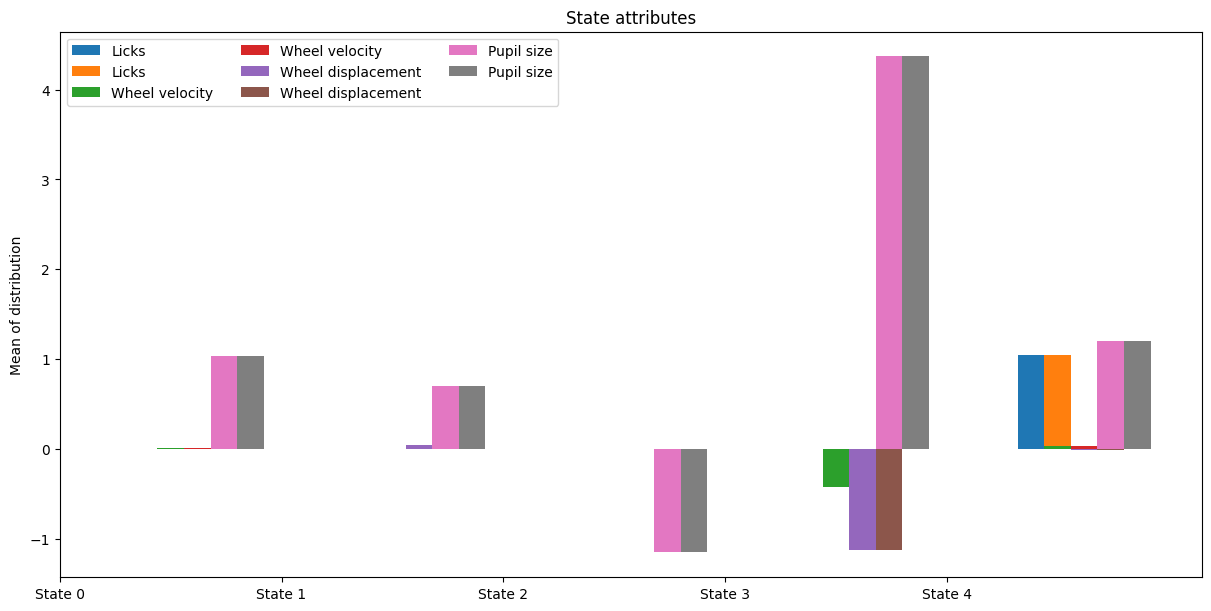

In [97]:

states = ('State 0', "State 1", "State 2", "State 3", 'State 4', 'State 5', 'State 6', 'State 7', 'State 8')
states = ('State 0', "State 1", "State 2", "State 3", 'State 4')
#states = ('State 0', "State 1", "State 2")

state_means = {
    'Licks': fit_params[2].means[0].T[0],
    'Wheel velocity': fit_params[2].means[0].T[1],
    'Wheel displacement': fit_params[2].means[0].T[2],
    'Pupil size': fit_params[2].means[0].T[3]
}

#state_means = {
#    'Wheel velocity': fit_params[2].means[0].T[0],
#    'Wheel displacement': fit_params[2].means[0].T[1],
#}

x = np.arange(len(states))  # the label locations
width = 0.12  # the width of the bars
multiplier = 0

#fig, ax = plt.subplots(figsize=[12, 6])  # layout='constrained', 
fig, ax = plt.subplots(layout='constrained', figsize=[12, 6])  # layout='constrained', 


for attribute, measurement in state_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement[0], width, label=attribute)
    rects = ax.bar(x + offset + width, measurement[1], width, label=attribute)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Mean of distribution')
ax.set_title('State attributes')
ax.set_xticks(x + width, states)
ax.legend(loc='upper left', ncols=3)
#ax.set_ylim(0, 250)

plt.show()

In [92]:
state_means

{'Licks': Array([[0.       , 0.       , 0.       , 0.       , 1.0420597],
        [0.       , 0.       , 0.       , 0.       , 1.0420597]],      dtype=float32),
 'Wheel velocity': Array([[ 1.4555797e-02,  1.3528564e-03,  1.2697054e-04, -4.2056191e-01,
          3.7985913e-02],
        [ 1.4555797e-02,  1.3528564e-03,  1.2697054e-04, -4.2056191e-01,
          3.7985913e-02]], dtype=float32),
 'Wheel displacement': Array([[-9.2619372e-04,  4.2152669e-02,  4.7697473e-04, -1.1195651e+00,
         -6.7085256e-03],
        [-9.2619372e-04,  4.2152669e-02,  4.7697473e-04, -1.1195651e+00,
         -6.7085256e-03]], dtype=float32),
 'Pupil size': Array([[ 1.0317593 ,  0.69891876, -1.1505191 ,  4.3674836 ,  1.202293  ],
        [ 1.0317593 ,  0.69891876, -1.1505191 ,  4.3674836 ,  1.202293  ]],      dtype=float32)}

In [89]:
measurement

Array([[0.       , 0.       , 0.       , 0.       , 1.0420597],
       [0.       , 0.       , 0.       , 0.       , 1.0420597]],      dtype=float32)

## Plot results from best fold

In [98]:
# Find best fold (this is what Zoe does)
use_fold = np.where(val_lls==np.max(val_lls))[0][0]
use_train = jnp.concatenate([train_emissions[:use_fold-1], train_emissions[use_fold:]])
use_val = train_emissions[use_fold]
print(use_fold)

3


In [99]:
# Initialize new hmm
#new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
new_hmm = GaussianMixtureHMM(num_states, component, emission_dim, transition_matrix_stickiness=10.) 
params, props = new_hmm.initialize(key=jr.PRNGKey(0), method="kmeans", emissions=use_train)
# Fit model to train data
fit_params, train_lps = new_hmm.fit_em(params, props, use_train, 
                                        num_iters=num_iters, verbose=False)
# Get state estimates for validation data
most_likely_states = new_hmm.most_likely_states(fit_params, use_val)
# Pad states array to have the same size as the whole data
complete_most_likely_states = np.concatenate([np.zeros(len(use_val)*use_fold)* np.nan, most_likely_states, np.zeros(len(use_val)*(use_fold+1))* np.nan]) # hard-coded for now
# Compute log likelihood on the validation data
lls = new_hmm.marginal_log_prob(fit_params, use_val)

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(44042, 5)


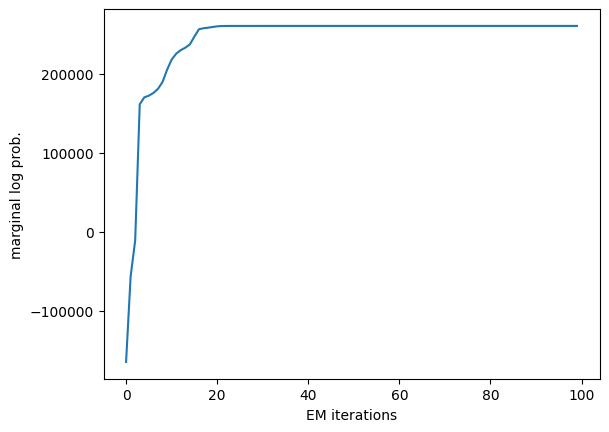

In [100]:
# Plot the marginal log probs across EM iterations
plt.plot(train_lps)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")

# Use fitted model for posterior inference
post = new_hmm.smoother(params, standardized_matrix)
print(post.smoothed_probs.shape) # (1000, 3)

#### Plot occupancy of states on validation data

(array([ 108.,    0., 3137.,    0.,    0.,  250.,    0., 3525.,    0.,
        1788.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

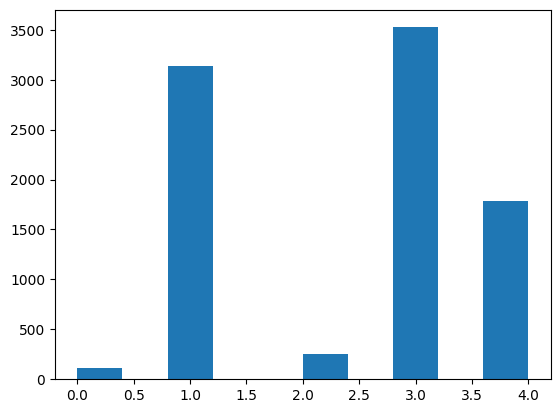

In [101]:
plt.hist(most_likely_states)

#### Plot states per event and split per side or correct incorrect

/tmp/ipykernel_48822/2234627360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_design_matrix['most_likely_states'] = most_likely_states
/tmp/ipykernel_48822/2234627360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
/tmp/ipykernel_48822/2234627360.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

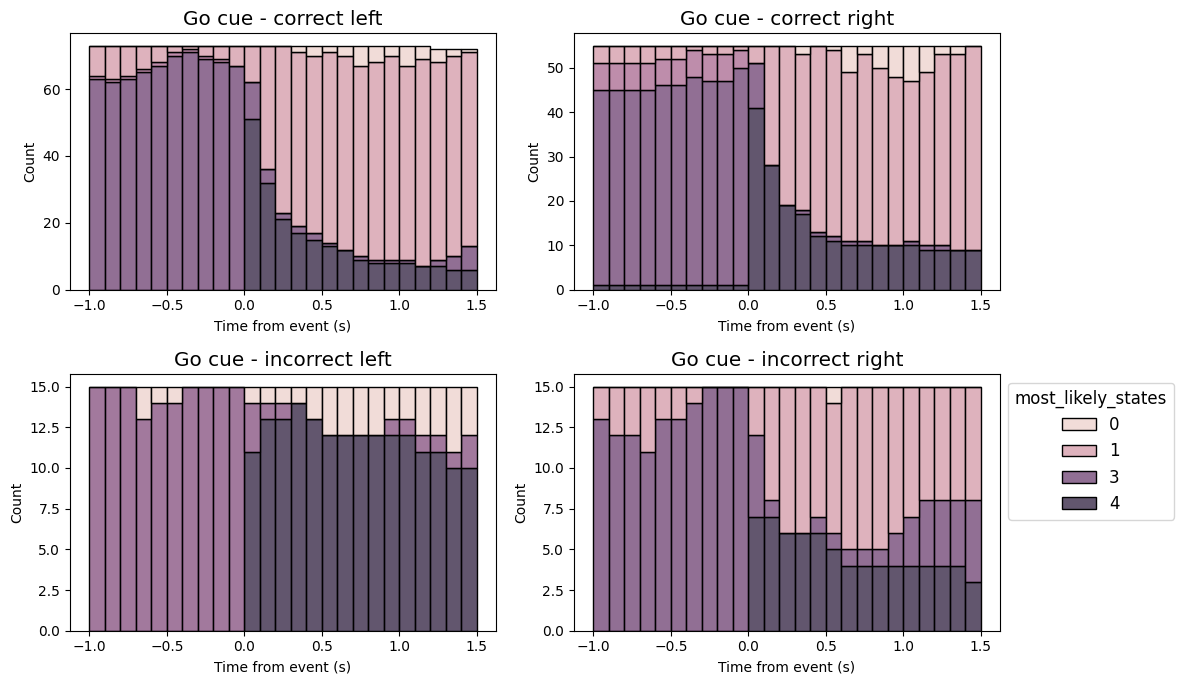

/tmp/ipykernel_48822/2234627360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_design_matrix['most_likely_states'] = most_likely_states
/tmp/ipykernel_48822/2234627360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
/tmp/ipykernel_48822/2234627360.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

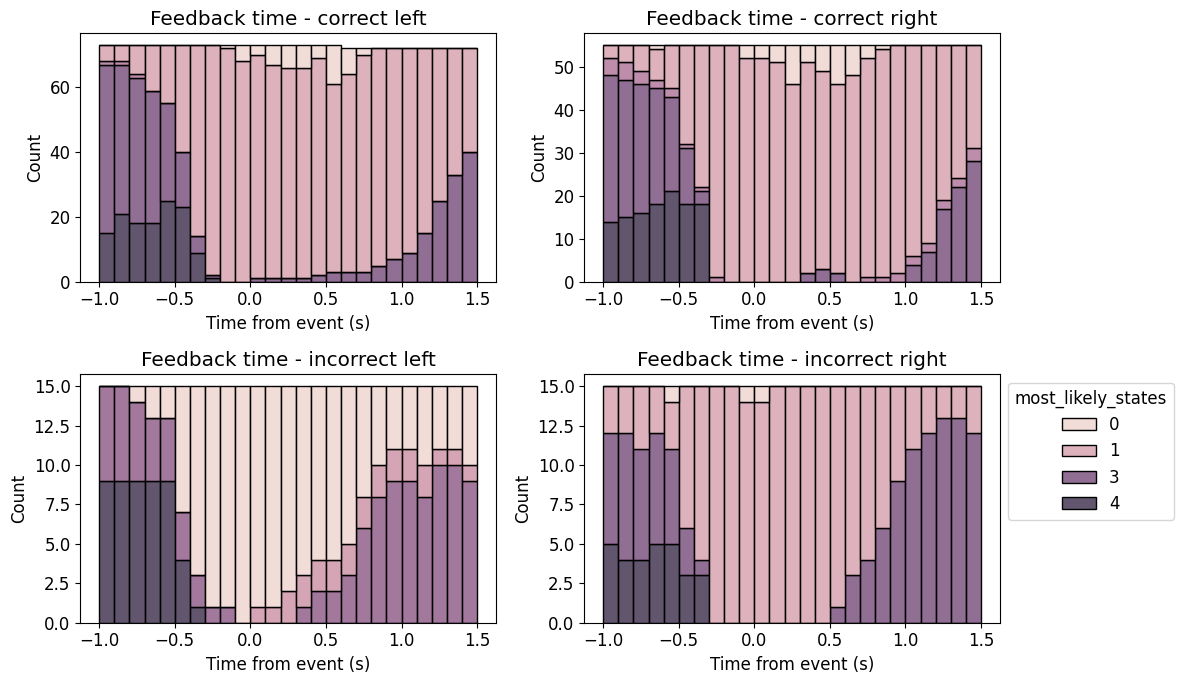

/tmp/ipykernel_48822/2234627360.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_design_matrix['most_likely_states'] = most_likely_states
/tmp/ipykernel_48822/2234627360.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
/tmp/ipykernel_48822/2234627360.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

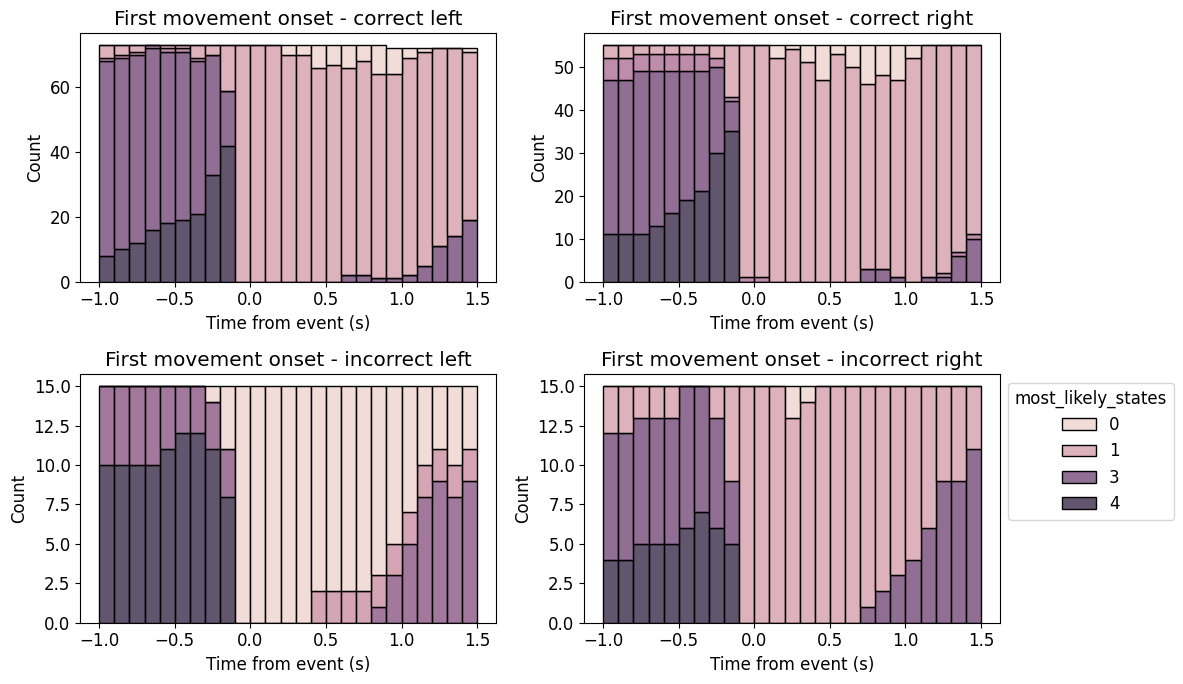

In [102]:
init = -10
end = 15

event_type_list = ['goCueTrigger_times', 'feedback_times', 'firstMovement_times']
event_type_name = ['Go cue', 'Feedback time', 'First movement onset']

for e, this_event in enumerate(event_type_list):
    
    # Initialize variables
    reduced_design_matrix = design_matrix[len(use_val)*use_fold:len(use_val)*(use_fold+1)]
    reduced_design_matrix['most_likely_states'] = most_likely_states
    reduced_design_matrix['new_bin'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['correct'] = reduced_design_matrix['Bin'] * 0
    reduced_design_matrix['choice'] = reduced_design_matrix['Bin'] * 0
    
    events = session_trials[this_event]
    feedback = session_trials['feedbackType']
    choice = session_trials['choice']
    state_stack = np.zeros((len(events), end + init)) * np.nan
            
    for t, trial in enumerate(events[2:-2]):
        event = events[t]
        
        # Check feedback
        if feedback[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) &
                                        (reduced_design_matrix['Bin']> event*10 + init), 
                                        'correct'] = 1
        elif feedback[t] == 0:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) &
                                        (reduced_design_matrix['Bin']> event*10 + init), 
                                        'correct'] = 0
        # Check choice
        if choice[t] ==1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) &
                                        (reduced_design_matrix['Bin']> event*10 + init), 
                                        'choice'] = 'right'
        elif choice[t] == -1:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) &
                                        (reduced_design_matrix['Bin']> event*10 + init), 
                                        'choice'] = 'left'
        
        if event > 0:
            event_window = reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) & (reduced_design_matrix['Bin']> event*10 + init)]
            if len(event_window)>0:
                bin = list(reduced_design_matrix.loc[reduced_design_matrix['Bin']>= event*10, 'Bin'])[0]
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) &
                                        (reduced_design_matrix['Bin']> event*10 + init), 
                                        'new_bin'] = reduced_design_matrix.loc[(reduced_design_matrix['Bin']< event*10 + end) & 
                                        (reduced_design_matrix['Bin']>= event*10 + init), 'Bin'] - bin
            else:
                reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) & (reduced_design_matrix['Bin']> event*10 + init), 'new_bin'] = np.nan
        else:
            reduced_design_matrix.loc[(reduced_design_matrix['Bin']<= event*10 + end) & (reduced_design_matrix['Bin']> event*10 + init), 'new_bin'] = np.nan

    # PLOT

    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, sharey=False, figsize=[12, 7])
    plt.rc('font', size=12)
    
    use_data = reduced_design_matrix.dropna()
    use_data['new_bin'] = use_data['new_bin'] * 0.1
    
    # Correct left
    a = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='left')], stat='count', 
                     multiple="stack", binwidth=.1, binrange=(0.1*init,0.1*end), legend=False, ax = ax[0, 0])
    # Correct right
    b = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==1) 
                                                                              & (use_data['choice']=='right')], stat='count', 
                     multiple="stack", binwidth=.1, binrange=(0.1*init,0.1*end), legend=False, ax = ax[0, 1])
    # Incorrect left
    c = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='left')], stat='count',
                     multiple="stack", binwidth=.1, binrange=(0.1*init,0.1*end), legend=False, ax = ax[1, 0])
    # Incorrect right
    d = sns.histplot(x='new_bin', hue='most_likely_states', data=use_data.loc[(use_data['correct']==0) 
                                                                              & (use_data['choice']=='right')], 
                     stat='count', multiple="stack", binwidth=.1, binrange=(0.1*init,0.1*end), ax = ax[1, 1])
    
    ax[0, 0].set_title(str(event_type_name[e] + ' - correct left'))
    ax[0, 0].set_xlabel(str('Time from event (s)'))
    
    ax[0, 1].set_title(str(event_type_name[e] + ' - correct right'))
    ax[0, 1].set_xlabel(str('Time from event (s)'))
    
    ax[1, 0].set_title(str(event_type_name[e] + ' - incorrect left'))
    ax[1, 0].set_xlabel(str('Time from event (s)'))
    
    ax[1, 1].set_title(str(event_type_name[e] + ' - incorrect right'))
    ax[1, 1].set_xlabel(str('Time from event (s)'))
    sns.move_legend(d, "upper left", bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

### Plot predictors overlayed with states

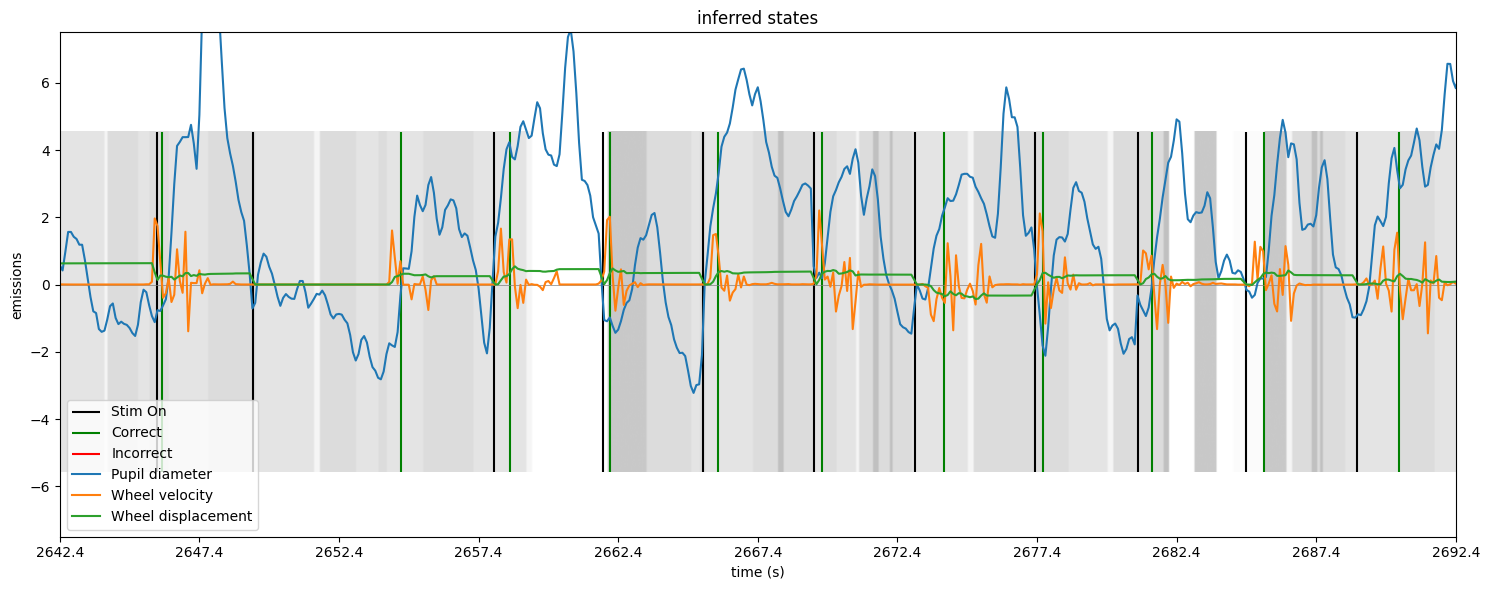

In [28]:
# Compute the most likely states
init = 00 + len(use_val)*2
end = 500 + len(use_val)*2

init = 00 + len(use_val)*3
end = 500 + len(use_val)*3

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

axs.imshow(
    complete_most_likely_states[None,:], 
    extent=(0, len(complete_most_likely_states), np.min(use_val) -.5, np.max(use_val) + .5),
    aspect="auto",
    cmap="Greys",
    alpha=0.25) #extent=(0, end-init, np.min(test_set) -.5, np.max(test_set) + .5),
axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
axs.plot(design_matrix['Bin'], design_matrix['pupil_subtracted'], label='Pupil diameter')
axs.plot(design_matrix['Bin'], design_matrix['avg_wheel_vel'], label='Wheel velocity')
axs.plot(design_matrix['Bin'], design_matrix['wheel_subtracted'], label='Wheel displacement')

axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 7.5)

axs.set_ylabel("emissions")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("inferred states")
plt.legend()
plt.tight_layout()

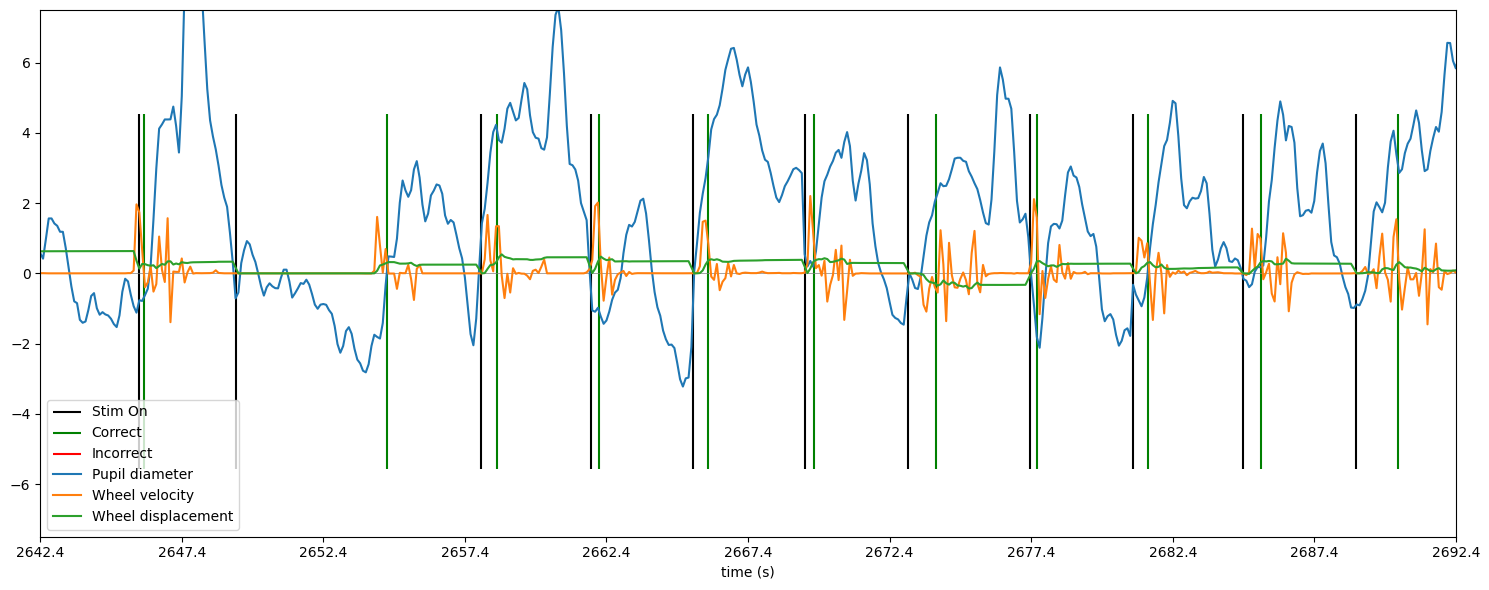

In [413]:
# Compute the most likely states
init = 00 + len(use_val)*2
end = 500 + len(use_val)*2
init = 00 + len(use_val)*3
end = 500 + len(use_val)*3

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(15, 6))

axs.vlines(np.array(session_trials['goCueTrigger_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Stim On', color='Black')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Correct', color='Green')
axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='Incorrect', color='Red')
#axs.vlines(np.array(session_trials['firstMovement_times'] * 10), np.min(use_val) -.5, np.max(use_val) + .5, label='First movement', color='Blue')
axs.hlines(0, init, end, color='Gray', linewidth=.5)

# Plot original values
axs.plot(design_matrix['Bin'], design_matrix['pupil_subtracted'], label='Pupil diameter')
axs.plot(design_matrix['Bin'], design_matrix['avg_wheel_vel'], label='Wheel velocity')
axs.plot(design_matrix['Bin'], design_matrix['wheel_subtracted'], label='Wheel displacement')

axs.set_ylim(np.min(use_val) -.5, np.max(use_val) + .5)
axs.set_ylim(-7.5, 7.5)

axs.set_ylabel("")
axs.set_xlabel("time (s)")
axs.set_xlim(init, end)
axs.set_xticks(np.arange(init, end+50, 50),np.arange(init/10, end/10+5, 5))

axs.set_title("")
plt.legend()
plt.tight_layout()


(14682, 2)


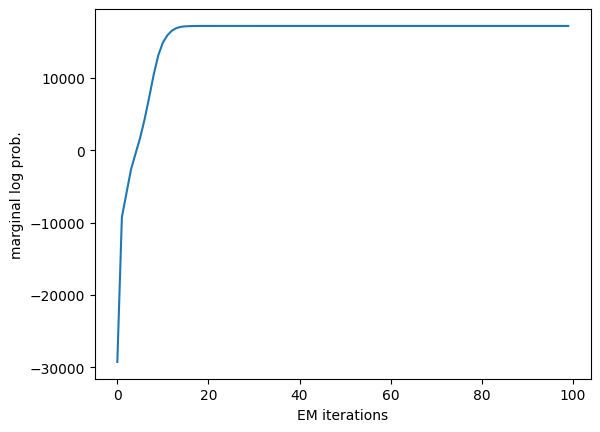

In [98]:
# Make a Gaussian HMM and sample data from it
hmm = GaussianHMM(num_states, emission_dim, transition_matrix_concentration=1)
#true_params, _ = hmm.initialize(key1)
#true_states, emissions = hmm.sample(true_params, key2, num_timesteps)

# Make a new Gaussian HMM and fit it with EM
params_init, props = hmm.initialize(key3, method="kmeans", emissions=standardized_matrix)
params, lls = hmm.fit_em(params_init, props, standardized_matrix, num_iters=100)

# Plot the marginal log probs across EM iterations
plt.plot(lls)
plt.xlabel("EM iterations")
plt.ylabel("marginal log prob.")

# Use fitted model for posterior inference
post = hmm.smoother(params, standardized_matrix)
print(post.smoothed_probs.shape) # (1000, 3)